Based off of work done by Frost Et al in PlosBiology, 2021: https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3001235

## Goal:
Develop a set of neural networks that are able to evaluate the information content contained within the correlation structure of matrices containing neural time-series

In [1]:
### Import all the necessary libraries
#!pip install --upgrade numpy #need numppy 1.7 to use code
import scipy.io
import numpy as np
import matplotlib
import random 

from matplotlib import pyplot as plt

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms, utils
from torchvision.utils import save_image
from torchvision.transforms import ToTensor

from google.colab import drive
drive.mount('/content/drive')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
print(np.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using cpu device
1.21.5


In [2]:
def make_rand_labels(label_len):
  rand_vec = np.random.rand(1, label_len) >= 0.5
  return rand_vec.astype(int)

### Import real sample data saved in google drive


In [3]:
mat_filename = '/content/drive/MyDrive/' + 'Dx_7-1_RS1_VEH_Spikes_thresh.mat'
mat = scipy.io.loadmat(mat_filename);
spikes = mat['spikes'] #extract numpy array of raster

#import real (sample) label vector 
real_label_filename = '/content/drive/MyDrive/' + 'Dlx_C7-1_RS1_VEH_paddedLabels.mat'
label_mat = scipy.io.loadmat(real_label_filename);
label_vector= label_mat[list(label_mat.keys())[3]][0]

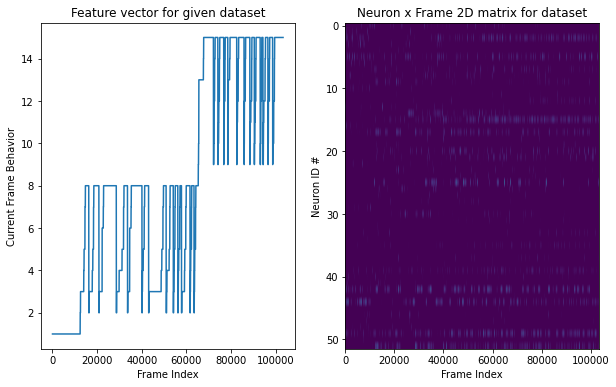

In [4]:
fig, ax = plt.subplots(1,2, figsize = (10,6))

ax[0].plot(label_vector);
ax[0].set_title("Feature vector for given dataset");
ax[0].set_xlabel('Frame Index');
ax[0].set_ylabel('Current Frame Behavior');

ax[1].imshow(spikes, aspect = 'auto');
ax[1].set_title("Neuron x Frame 2D matrix for dataset");
ax[1].set_xlabel('Frame Index');
ax[1].set_ylabel('Neuron ID #');

In [5]:
#make prediction and losses dict for later 
predictions_dict = dict()
losses_dict = dict()
report_info = dict()

new random vector shape is (1, 103362)


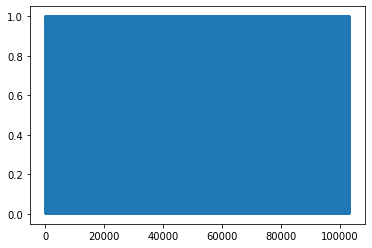

In [6]:
# make deterministic raster for testing network
random_label_vec = make_rand_labels(label_vector.shape[0])

label_mask = random_label_vec == 1
label_mask = label_mask #create numpy boolean mask for indexing

print('new random vector shape is' , random_label_vec.shape)
plt.plot(random_label_vec.ravel());

### Testing pytorch network on simulated dataset
To verify the network architecture is able to learn, a sample dataset is created, of equal size as the real calcium dataset (Neuron x Observation matrix) . This dataset has activity (defined as Element in row n, column o/E_n,o = 1)in a subset of simulated units. The network is then trained on said simulated dataset.

new raster shape is(50, 103362)


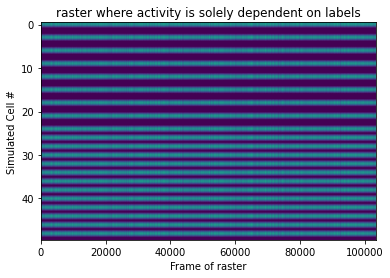

In [7]:

d_raster_size = 50
#create raster that is dependent on random labels
dependent_raster = np.zeros((d_raster_size,label_mask.shape[1]))
dependent_raster[0:round(d_raster_size/2):3, label_mask.ravel()] = 1
dependent_raster[round(d_raster_size/2)+1::2, label_mask.ravel()] = 1

print('new raster shape is' + str(dependent_raster.shape))

plt.imshow(dependent_raster, aspect = 'auto' );
plt.title('raster where activity is solely dependent on labels');
plt.xlabel('Frame of raster');
plt.ylabel('Simulated Cell #');

In [8]:
## NETWORK CLASS STORAGE
#build neural network based off frost et al., with 1000 hidden layer units outputting to a single sigmoid output unit
#Most importantly, this network will use mean squared error as the loss funciton 
class frost_net(nn.Module):
    def __init__(self): #input in the number of neurons you want to use 
        super(frost_net, self).__init__()
        self.fc1 = nn.Linear(1000, 1) #1000 neurons in, 1 OUT
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #need to transpose X, as linear layers require (, Xin) shaped tensors
        x = self.fc1(x.float()) #pass 1st layer input (numNeurons ->1000),
        #frost et al. just feed data directly from input to hidden layer
        x = self.sigmoid(x) #then apply sigmoid for output
        return x


In [9]:
#replicate frost et al., architecture
# randomly set up weights from the input neurons to the hidden layer units
def make_random_connections(num_cells, num_hidden_units, connect_prob):
    #to be fed into the 1000 x 1 input/hiddne unit layer, you need it to be 1 x 1000 input matrix
    rand_matrix = np.random.rand(num_cells, num_hidden_units) <= connect_prob #everything LESS than connection problem is a 1
    return rand_matrix 

def sum_rand_connect_to_hidden_layer(random_connection_matrix, real_dataset):     #this takes a given connection matrix, and sums up each frame of the real dataset
    summed_HL_input = np.empty((real_dataset.shape[1], random_connection_matrix.shape[1] )) #number of frames BY number of HL units
#    for each unit, during each run, the input neurons are the same across the ENTIRE dataset
    for hidden_unit_ID in np.arange(random_connection_matrix.shape[1]):
        input_to_HL_unit = real_dataset[random_connection_matrix[:, hidden_unit_ID], :] #take all columns of the neurons that are boolean True connected to unit 
        summed_HL_input[:, hidden_unit_ID] = np.sum(input_to_HL_unit,axis = 0) #this outputs a boolean
    return summed_HL_input
    #turn the sum into a torch tensor
    #you want to feed out a num_frame x 1000 matrix, so when you index i it's the right input to the matrix 
    #return summed_HL_input #size iwll be num Frame rows, hidden layer columns

(50, 1000)


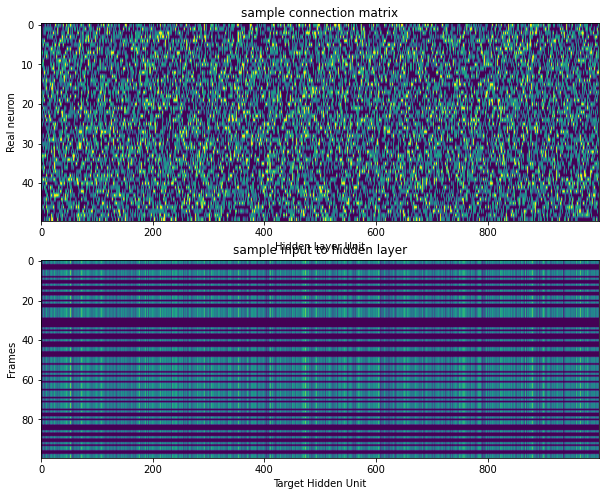

In [10]:
rand_conn_matrix = make_random_connections(50,1000, 0.3)
sum_input = sum_rand_connect_to_hidden_layer(rand_conn_matrix, dependent_raster[:, 0:100])
print(rand_conn_matrix.shape)
#show the connection matrix to verify it's working
fig, ax= plt.subplots(2, figsize = (10,8))

ax[0].imshow(rand_conn_matrix, aspect = 'auto');
ax[0].set_title('sample connection matrix');
ax[0].set_xlabel('Hidden Layer Unit');
ax[0].set_ylabel('Real neuron');

ax[1].imshow(sum_input, aspect = 'auto');
ax[1].set_title('sample input to hidden layer');
ax[1].set_xlabel('Target Hidden Unit');
ax[1].set_ylabel('Frames');

In [11]:
def train_loop_conn_matrix(connection_matrix, dataset, labels, model, loss_fn, optim_obj, min_act):
    sigmoid_thresh = 0.5 #set sigmoid threshold 
    
    #labels needs to be converted to torch before injecting, dataset is transformed in function
    #threshold dataset to frames with activity in it
    num_active_threshold = min_act  #how many neurons ought to be active within a frame for it to be used as input
    activity_bool_mask = np.sum(dataset, axis = 0) >= min_act  #want to create a 1 x Frame vector, where each element is the summed activty, then make bool if > threshold
    
    #threshold both dataset and labels 
    dataset = dataset[:, activity_bool_mask]
    labels = labels[activity_bool_mask]
    #transform dataset to tensor form of post-transformed hidden unit input layer 
    ensemble_transform_dataset = torch.from_numpy(sum_rand_connect_to_hidden_layer(connection_matrix, dataset)) #need to convert this to a tensor
    #create loss, prediction storage
    loss_array = np.empty((labels.shape[0])) #one loss entry for every element in the element vector (e.g. SGD loss)
    prediction_array = np.empty((labels.shape[0])) #one prediction entry for every element in the element vector 
    prediction_thresholded_array = np.empty((labels.shape[0])) #one THRESHOLDED prediction entry for every element in the element vector 

    for example_index in np.arange(labels.shape[0]):
        #to be fed into the 1000 x 1 input/hiddne unit layer, you need it to be 1 x 1000 input matrix
        prediction = model(ensemble_transform_dataset[example_index,:]) #take the example index and slice into dataset with it 
        prediction_thresholded = prediction > sigmoid_thresh
        #print(prediction.shape, labels[example_index].view(1).shape) #for debug shape mismatch

        prediction_loss = loss_fn(prediction.view(1).float(), labels[example_index].view(1).float())
        prediction_array[example_index] = prediction.float()
        prediction_thresholded_array[example_index] = prediction_thresholded.float()
        #run backpropogation
        optim_obj.zero_grad() #clear the gradient vector
        prediction_loss.backward()# send the loss backwards through the network
        optim_obj.step()# then move the opimizer 

        if example_index %200 == 0:
            print('running example: ', example_index)
        loss_array[example_index] = prediction_loss.item() #.item returns the tensor's value independent from the gradient
    
    print(prediction_array.shape, labels.shape)
    accuracy =  np.sum(prediction_thresholded_array == labels.numpy())/labels.shape[0] 
    mean_loss_all_examples = np.mean(loss_array) #you need to transform the loss array into single value of MSE
    return mean_loss_all_examples, accuracy, loss_array, prediction_array, prediction_thresholded_array


In [12]:
#set what input label and raster will be 
input_raster = dependent_raster #set up the right pointer
input_labels = random_label_vec 
rand_conn_matrix = make_random_connections(input_raster.shape[0],1000, 0.3)#start off a run with making a rand connection matrix of size (ROWs of input raster)

#create instance of model
frost_test = frost_net()
#declare parameters
learning_rate = 0.05
#instantiate loss function and optimizer
loss_function = nn.MSELoss()
frost_optimizer = torch.optim.SGD(frost_test.parameters(), lr = learning_rate)
print('neural network params are :' , frost_test) 

#run training loop 
train_index_start = 0
train_index_end = 1000
print("training index size is :" , torch.from_numpy(input_labels[0,train_index_start:train_index_end]).shape[0])
mean_loss_all_examples, accuracy, test_loss_array, prediction_array, prediction_thresholded_array = train_loop_conn_matrix(rand_conn_matrix, input_raster[:, train_index_start:train_index_end], torch.from_numpy(input_labels[0,train_index_start:train_index_end]), frost_test, loss_function, frost_optimizer, 0)


neural network params are : frost_net(
  (fc1): Linear(in_features=1000, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
training index size is : 1000
running example:  0
running example:  200
running example:  400
running example:  600
running example:  800
(1000,) torch.Size([1000])


#### Running real labels on real dataset: Feature 1

Here I will be training a network architecture identical to that used in the simulated network example, to predict whether a given frame of the recording is the ITI period or not. 

In [13]:
def make_oneHot_vector_singleBEI(label_vec, BEI, comparison):
#TO: take  a label vector of ordinal features, perform a comparison with the value of interest, and return a boolean feature vector
  #INPUT must be numpy array
  if comparison == '=':
    feature_vec_bool = label_vec == BEI
  elif comparison == '>':
    feature_vec_bool = label_vec > BEI
  elif comparison == '<':
    feature_vec_bool = label_vec < BEI
  elif comparison == 'multi =': #check if eleemtn in list is = to any element of BEI list 
    print(BEI[0])
    feature_vec_bool = np.logical_or(label_vec == BEI[0], label_vec == BEI[1])
  #now prepare vec for output
  zero_vector = np.zeros((1, label_vec.shape[0]), dtype = bool)
  zero_vector[0,feature_vec_bool] = bool(1)
  return zero_vector

def generate_balanced_train_index(index_class_1, index_class_2, num_examples, join_type):
    random_class1_index = np.random.choice(index_class_1, (num_examples), replace = False) #sample without replacement, picking (num_train_examples) elements, from array of (indexes where class = True)
    random_class2_index = np.random.choice(index_class_2, (num_examples), replace = False)
    #print('shape of c1 index is ', random_class1_index.shape)
    #print('shape of c2 index is ', random_class2_index.shape)
    if join_type == 'concat':
        training_index = np.concatenate((random_class1_index, random_class2_index))
    elif join_type == 'mix':
        training_index = np.empty((random_class1_index.shape[0] + random_class2_index.shape[0],))# makes empty 0 by index_class size empty array
        #print('shape of mixed train index is ', training_index.shape)
        training_index[0::2] = random_class1_index[:]#index into it with eveyr other elements
        training_index[1::2] = random_class2_index[:]#index into it with eveyr other elements

    return training_index.astype(int)

In [14]:
#these lists can be index randomly, then combined to give random combinations of true and false data for the network
IA_vec = make_oneHot_vector_singleBEI(label_vector, [9], '<')
num_train_examples = 1000

feature_vec_range = np.arange(0,IA_vec.shape[1])
print('feature vec range shape is', feature_vec_range.shape)
print('IA vec shape is ', IA_vec.shape)

invert_feature_vec = np.invert(IA_vec)
index_is_true = feature_vec_range[ IA_vec[0,:]]
index_is_false = feature_vec_range[invert_feature_vec[0,:]]

#set what input label and raster will be 
input_raster = spikes #set up the right pointer
input_labels = IA_vec 

#create instance of model
frost_IA = frost_net()

#declare parameters
learning_rate = 0.05
#instantiate loss function and optimizer
loss_function = nn.MSELoss()
frost_optimizer = torch.optim.SGD(frost_IA.parameters(), lr = learning_rate)
print('neural network params are :' , frost_IA) 

#make training loop  params
num_train_examples = 10000
num_epochs = 500
loss_record_IA = list()
acc_record_IA = list()
rand_conn_matrix = make_random_connections(input_raster.shape[0],1000, 0.3)#start off a run with making a rand connection matrix of size (ROWs of input raster)

## start train loop
for e in np.arange(num_epochs):

    balance_train_index = generate_balanced_train_index(index_is_true, index_is_false, num_train_examples, 'mix') #make new balanced train index
    mean_loss_all_examples, accuracy, test_loss_array, prediction_array, prediction_thresholded_array =  train_loop_conn_matrix(rand_conn_matrix, input_raster[:,balance_train_index], torch.from_numpy(input_labels[0,balance_train_index]), frost_IA, loss_function, frost_optimizer, 2)
    loss_record_IA.append(mean_loss_all_examples)
    acc_record_IA.append(accuracy)


feature vec range shape is (103362,)
IA vec shape is  (1, 103362)
neural network params are : frost_net(
  (fc1): Linear(in_features=1000, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
running example:  0
running example:  200
running example:  400
running example:  600
running example:  800
running example:  1000
(1144,) torch.Size([1144])
running example:  0
running example:  200
running example:  400
running example:  600
running example:  800
running example:  1000
(1160,) torch.Size([1160])
running example:  0
running example:  200
running example:  400
running example:  600
running example:  800
running example:  1000
(1122,) torch.Size([1122])
running example:  0
running example:  200
running example:  400
running example:  600
running example:  800
running example:  1000
running example:  1200
(1227,) torch.Size([1227])
running example:  0
running example:  200
running example:  400
running example:  600
running example:  800
running example:  1000
(1138,) torch.Size([113

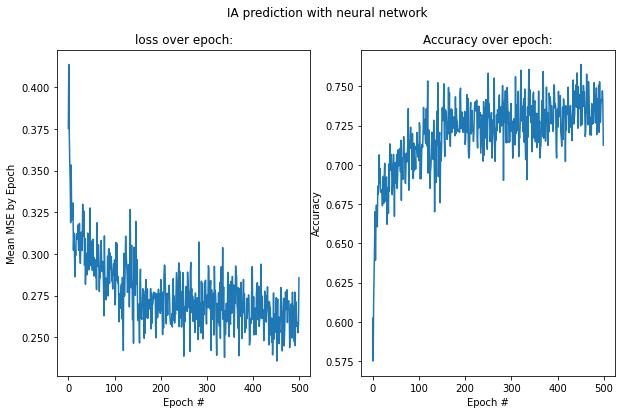

In [15]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize = (10,6))
fig.suptitle('IA prediction with neural network')

ax1.plot(loss_record_IA);
ax1.set_title('loss over epoch:');
ax1.set_xlabel('Epoch #');
ax1.set_ylabel('Mean MSE by Epoch');

ax2.plot(acc_record_IA);
ax2.set_title('Accuracy over epoch:')
ax2.set_xlabel('Epoch #');
ax2.set_ylabel('Accuracy');

#loss_record_IA = np.concatenate(loss_record_IA) #turn list of arrays into stacked array